In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T082818Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9a88fa759a413f730123e0bcc0139c38743abefe6dd5503ecdc087968609c57d027a6812185296a54438df2a5eeb99cb46068f61c5d3d74686ac9b3eef8f066aebbb84814e12eef233110557bd17521737f8d625280f382c5515ed3e68cc1a71e4f4feafb3ef2acdfad01b396e05371df908f0ef15fad91adb263fdb90312b0fe9cafad6ee680c4614f2b36ac38108cbe718d8eac9b3178c28c37e85cc12f09b44bf02a8f7191d5ce9f25f747b5ed937bc8d91b87463cee35f89939fd7fa99f6b6967f17b42dd9874fe40198593f4ce0077887495cc2068225217129a7a4967e01653ad9cccd2aad63e69f9ec68c3592d4fca30eb6bdd592e2af7f2cda35c2a9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


**SMS CLASSIFIER DATASET**

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df=pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding="latin-1")

In [ ]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


**DATA PREPROCESSING AND CLEANING**

In [ ]:
df.drop("Unnamed: 2",inplace=True,axis=1)
df.drop("Unnamed: 3",inplace=True,axis=1)
df.drop("Unnamed: 4",inplace=True,axis=1)
df.sample(10)

,v1,v2
1706,ham,Yes! I am a one woman man! Please tell me your...
3143,ham,"Haha I heard that, text me when you're around"
836,spam,Do you want 750 anytime any network mins 150 t...
2827,ham,Wife.how she knew the time of murder exactly
623,ham,"sorry, no, have got few things to do. may be i..."
3749,ham,"Buzz! Hey, my Love ! I think of you and hope y..."
1925,ham,We don call like &lt;#&gt; times oh. No give...
4183,ham,I just really need shit before tomorrow and I ...
3858,spam,Win the newest åÒHarry Potter and the Order of...
4072,ham,Was the actual exam harder than NBME


**STEMMING THE CLEANED DATA AND REMOVING STOPWORDS**

In [ ]:
def clean_data(text):
    text=text.lower()
    words=re.sub('[^a-z]',' ',text)

    stop_words=set(stopwords.words("english"))
    text=' '.join([word for word in words.split() if word not in stop_words])
    stemmer=PorterStemmer()
    text=' '.join([stemmer.stem(word) for word in words.split()])
    return text
clean_text=df['v2'].apply(clean_data)
print(clean_text.head())

0    go until jurong point crazi avail onli in bugi...
1                                ok lar joke wif u oni
2    free entri in a wkli comp to win fa cup final ...
3          u dun say so earli hor u c alreadi then say
4    nah i don t think he goe to usf he live around...
Name: v2, dtype: object


**VECTORIZING THE DATASET AND CREATING TESTING AND TRAINING SPLITS**

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_text)
y = df['v1'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (4457, 6321)
Testing set shape: (1115, 6321)


**USING DIFFERENT MODELS TO FIND BEST PERFORMANCE**

Accuracy: 0.967713004484305
Classification Report:
               precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       965
        Spam       1.00      0.76      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy with CV:  0.9661183050335064


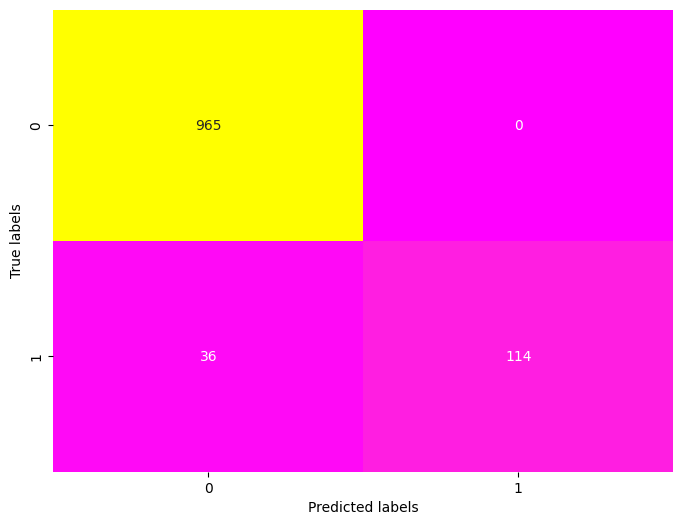

In [ ]:
logreg=LogisticRegression(random_state=42)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])

print('Accuracy:', accuracy)
print('Classification Report:\n', report)
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print("Accuracy with CV: ",scores.mean())
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="spring", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy: 0.967713004484305
Classification Report:
               precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       965
        Spam       0.89      0.87      0.88       150

    accuracy                           0.97      1115
   macro avg       0.93      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy with CV:  0.9667914546279034


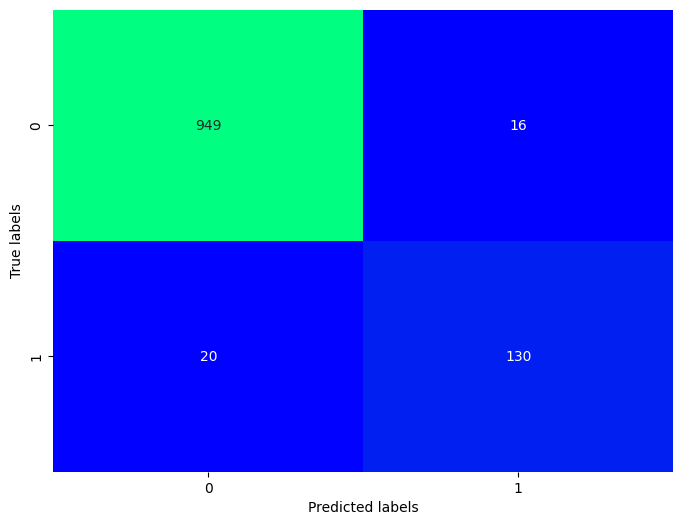

In [ ]:
DTC=DecisionTreeClassifier()
DTC.fit(X_train,y_train)
y_pred=DTC.predict(X_test)
accuracy1=accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])

print('Accuracy:', accuracy1)
print('Classification Report:\n', report)
scores = cross_val_score(DTC, X_train, y_train, cv=10)
print("Accuracy with CV: ",scores.mean())
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="winter", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy: 0.9775784753363229
Classification Report:
               precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.99      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy with CV:  0.979581800775936


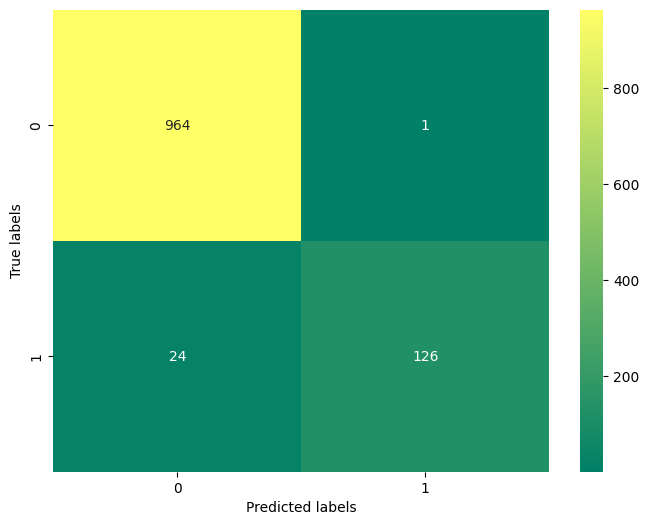

In [ ]:
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
accuracy2=accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])

print('Accuracy:', accuracy2)
print('Classification Report:\n', report)
scores = cross_val_score(svc, X_train, y_train, cv=10)
print("Accuracy with CV: ",scores.mean())
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="summer", cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

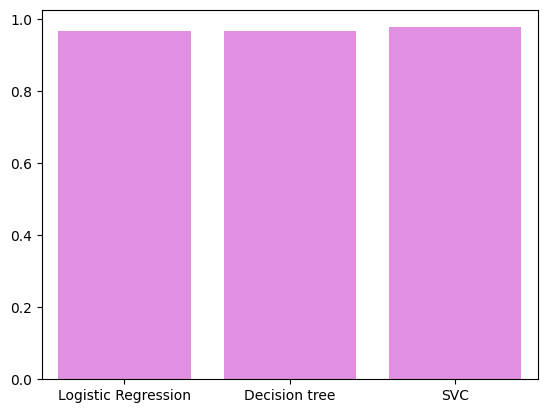

In [ ]:
classifiers = ['Logistic Regression','Decision tree','SVC']
acc=[accuracy,accuracy1,accuracy2]
sns.barplot(x=classifiers,y=acc,color='violet')
